In [3]:
# imports 
import time
import numpy as np
import matplotlib.pyplot as plt

import jax
import optax
import jax.nn as jnn

import jax.numpy as jnp
import jax.random as jnr
import jax.scipy as jsp
from jax.example_libraries import optimizers
import pyswarm

import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5

## Dynamics Model

### Pure Mechanistic Model of Crystallisation of K2SO4


From the following [source](https://pubs.acs.org/doi/10.1021/acs.iecr.3c00739)

$$ \frac{d}{dt}\begin{bmatrix} \mu_0 \\ \mu_1 \\ \mu_2 \\ \mu_3 \\ C \\ T  \end{bmatrix}  =  \begin{bmatrix} r_{nuc}\\ r_1 (\mu_0 + \gamma \mu_1 ) \\ 2r_1 (\mu_1 +\gamma \mu_2) \\ 3r_1(\mu_2 +\gamma \mu_3) \\ f(\cdot)r_1(\mu_2 + \gamma \mu_3) \\ f(T, Tc)  \end{bmatrix}  $$



In [4]:
''' function to define the differential equations. Passed to diffeq solver '''

def true_dynamics(t, state, params):
  ka= 0.923714966
  kb= -6754.878558
  kc= 0.92229965554
  kd= 1.341205945
  kg= 48.07514464
  k1= -4921.261419
  k2= 1.871281405
  a= 0.50523693
  b= 7.271241375
  alfa= 7.510905767
  ro= 2.658  # g/cm³
  V= 0.0005  # m³
  ro_t= 997  # kg/m³
  Cp_t= 4.117  # kJ/kg*K
  UA= 0.2154  # kJ/min*K
  Tc = 273+40

  mu0, mu1, mu2, mu3, conc, temp = state


  Ceq = -686.2686 + 3.579165 * jnp.array(temp) - 0.00292874 * jnp.array(temp) ** 2  # g/L  


  S = jnp.array(conc) * 1e3 - Ceq  # g/L
  B0 = ka * jnp.exp(kb / temp) * (S ** 2) ** (kc / 2) * ((mu3 ** 2) ** (kd / 2))  # /(cm³*min)
  Ginf = kg * jnp.exp(k1 / temp) * (S ** 2) ** (k2 / 2)  # [G] = [Ginf] = cm/min


  dmi0dt = B0
  dmi1dt = Ginf * (a * mu0 + b * mu1 * 1e-4) * 1e4
  dmi2dt = 2 * Ginf * (a * mu1 * 1e-4 + b * mu2 * 1e-8) * 1e8
  dmi3dt = 3 * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12) * 1e12
  dcdt = -0.5 * ro * alfa * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12)
  dTdt = UA * (Tc - temp) / (V * ro_t * Cp_t)

  dxdt = jnp.array([dmi0dt, dmi1dt, dmi2dt, dmi3dt, dcdt, dTdt])
  return dxdt

In [5]:
def true_dynamics_rk4(params, t0, tf, steps, dt0, x0):
  term = ODETerm(true_dynamics)
  solver = diffrax.Kvaerno5()
  stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
  print(steps)
  saveat = SaveAt(ts=jnp.linspace(t0, tf, steps + 1))
  adjoint_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8, norm = diffrax.adjoint_rms_seminorm)
  adjoint = diffrax.BacksolveAdjoint(stepsize_controller=adjoint_controller)

  return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params, stepsize_controller=stepsize_controller, adjoint = adjoint, saveat = saveat, max_steps=100000).ys#[-1, :]

#return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params, saveat = saveat).ys


## Creating Dataset

Create samples based on true dynamics model.

In [6]:
def create_data(parameters, T0, TF, steps, step_size, x0):
  T = jnp.linspace(T0, TF, steps + 1)
  x_true = true_dynamics_rk4(parameters, T0, TF, steps, step_size, x0)
  jax.debug.print("True State Shape = {}".format(x_true.shape))

  random_noise = np.random.multivariate_normal(np.array([0]*x_true.shape[1]), np.diag(np.ones(x_true.shape[1])), steps + 1)
  x_obs = x_true * (1 + random_noise * 0.02)

  print("Observed State Shape = {}".format(x_obs.shape))

  return x_true, x_obs, T

In [7]:
def plot_samples(x_true, x_obs, T):
  font = {'family' : 'serif',
        'weight' : 'bold'}

  plt.rc('font', **font)
  label_tag = ['$\mu_0$', '$\mu_1$', '$\mu_2$', '$\mu_3$', 'C', 'T']
  for i in range(x_obs.shape[1]):
    plt.plot(T, (x_obs.T[i, :]- np.min(x_obs.T[i, :]))/(np.max(x_obs.T[i, :]) -np.min(x_obs.T[i, :])), '.', label = "Obs " + label_tag[i])
    plt.plot(T, (x_true.T[i, :]- np.min(x_obs.T[i, :]))/(np.max(x_obs.T[i, :])- np.min(x_obs.T[i, :])), '-', label = "True " + label_tag[i])

  plt.xlabel("Time")
  plt.ylabel("State")
  plt.title("Normalized state values over time")
  plt.legend()
  plt.show()

## Neural Network Model

The model presented above is semi-empirical given it incorporates a quadratic function of T to describe temperture dependence in the solute equilibrium concentration


$$ r_{nuc} = k_b \exp\left(\frac{-E_{Ab}}{RT}\right)ΔC^b\mu_3^\beta $$
$$\Delta C = C - C_s $$


$$ C_s(T) =-686.27 +3.5795T - 2.9287 \times 10^{-3}T^2  $$

with $C_s(T)$ identified in preliminary experiments.


Here, we will remove the quadratic expression from the model and try to learn the temperature dependence directly from reactor data as a neural network

$$ C_{eq}(T) = f_{NN}(T, \phi)$$


In [8]:
# , [0.5], [225.0] , [1],[100.0]
def input_scaler(inputs, scale_mean = jnp.array([155323e2*2, 2123753e2, 184700097, 2340672717.3,0.1605, 273+39.38]), scale_std = 0.5 ):
  # assumes state space bounded of NN is bounded by tanh
  return jnp.divide(inputs-scale_mean, jnp.divide(scale_mean,scale_std))

def minmax_scalar(inputs, range=jnp.array([3.6641571e+02]), mini=jnp.array([2.9449063e+02]) ):    # 3.1358778e+08, 2.6019895e+09, 7.2683312e+09, 3.8483950e+10,2.8258935e-01,     1.5750447e+03, 2.2706311e+04, 1.8967081e+06, 2.4140062e+08, 1.3892503e-01,
  return jnp.divide(inputs + mini, range)

def output_scaler(inputs, scale_min = -1, scale_max = 1):
  return jnp.multiply(jnp.divide(inputs + jnp.array([1]), jnp.array([2])), scale_max - scale_min) + scale_min

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:

''' Parameter initialization functions '''

def init_layer(m, n, rng):
  Wm_rng, bm_rng = jnr.split(rng, 2)
  std = 1./jnp.sqrt(n)
  W_mu = jnr.uniform(Wm_rng, (n, m), minval = -std, maxval = std)
  b_mu = jnr.uniform(bm_rng, (n, 1), minval = -std, maxval = std)

  params = {
      'W' : W_mu,
      'b' : b_mu }

  return params

def init_bnn_params(init_rng, sizes):
  rngs = jnr.split(init_rng, len(sizes))
  return {i:init_layer(m, n, k) for i, (k, m, n) in enumerate(zip(rngs, sizes[:-1], sizes[1:]))}

In [10]:
''' Prediction functions '''

def relu(x):
  return jnp.maximum(0, x)


def relu_6(x):
  return jnp.divide(jnp.minimum(6, jnp.maximum(0, x)),6)


def tanh(x):
  return jnp.tanh(x)


def predict(params, x):
  activations = x.reshape(-1,)

  activations = minmax_scalar(activations).reshape(-1,1)

  #jax.debug.print('x = {x}', x=activations)



  for i in range(len(params)-1):

    W = params[i]['W']
    b = params[i]['b']

    activations = tanh(jnp.dot(W, activations) + b)


  final_W = params[i+1]['W']
  final_b = params[i+1]['b']



  output = jnp.tanh(jnp.dot(final_W, activations) + final_b) + 1

  #jax.debug.print('x = {x}', x=output.squeeze()/2)

  return output.squeeze()/2

batched_predict = jax.vmap(predict, in_axes = (None, 0))

## Hybrid Model

In [11]:
''' function to define the differential equation using NN output for u_x '''

def hybrid_dynamics(t, state, params):
  ka= 0.923714966
  kb= -6754.878558
  kc= 0.92229965554
  kd= 1.341205945
  kg= 48.07514464
  k1= -4921.261419
  k2= 1.871281405
  a= 0.50523693
  b= 7.271241375
  alfa= 7.510905767
  ro= 2.658  # g/cm³
  V= 0.0005  # m³
  ro_t= 997  # kg/m³
  Cp_t= 4.117  # kJ/kg*K
  UA= 0.2154  # kJ/min*K
  Tc = 273+40

  mu0, mu1, mu2, mu3, conc, temp = state


  Ceq =  180 * predict(params, jnp.copy(temp)) # -686.2686 + 3.579165 * jnp.array(temp) - 0.00292874 * jnp.array(temp) ** 2  # g/L
  S = jnp.array(conc) * 1e3 - Ceq  # g/L

  B0 = ka * jnp.exp(kb / temp) * (S ** 2) ** (kc / 2) * ((mu3 ** 2) ** (kd / 2))  # /(cm³*min)
  Ginf = kg * jnp.exp(k1 / temp) * (S ** 2) ** (k2 / 2)  # [G] = [Ginf] = cm/min


  dmi0dt = B0
  dmi1dt = Ginf * (a * mu0 + b * mu1 * 1e-4) * 1e4
  dmi2dt = 2 * Ginf * (a * mu1 * 1e-4 + b * mu2 * 1e-8) * 1e8
  dmi3dt = 3 * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12) * 1e12
  dcdt = -0.5 * ro * alfa * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12)
  dTdt = UA * (Tc - temp) / (V * ro_t * Cp_t)

  dxdt = jnp.hstack([dmi0dt.reshape(1,1), dmi1dt.reshape(1,1), dmi2dt.reshape(1,1), dmi3dt.reshape(1,1), dcdt.reshape(1,1), jnp.array(dTdt).reshape(1,1)])

  return dxdt.squeeze()

## Integration Schemes for Hybrid Model

In [12]:
def hybrid_dynamics_rk4(params, t0, tf, steps, dt0, x0):
  term = ODETerm(hybrid_dynamics)
  solver = Tsit5()
  saveat = SaveAt(ts=jnp.linspace(t0, tf, steps + 1))

  return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params, saveat = saveat).ys

def hybrid_dynamics_rk4_1s(params, t0, tf, steps, dt0, x0):
  term = ODETerm(hybrid_dynamics)
  solver =diffrax.Kvaerno5()
  stepsize_controller = diffrax.PIDController(rtol=1e-1, atol=1e-1)
  saveat = SaveAt(ts=jnp.linspace(t0, tf, steps + 1))
  #print(saveat)
  #adjoint_controller = diffrax.PIDController(rtol=1e-1, atol=1e-2, norm = diffrax.adjoint_rms_seminorm)
  adjoint = diffrax.RecursiveCheckpointAdjoint()
  try:
    return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params,stepsize_controller=stepsize_controller, adjoint=adjoint, saveat = saveat, max_steps=100000).ys[-1, :]
  except:
    return x0


## Helper Functions

In [13]:
''' Root Mean Squared Error Loss '''

def rmse(x, y):
  return jnp.sqrt(jnp.mean(jnp.power(x - y, 2)))



## Negative Log Likelihood function

In [14]:
def initialise_Qmat(x_obs):
  Qmat = jnp.diag(jnp.power(jnp.std(x_obs.T, axis = 1), 2))
  Qmat = jnp.linalg.inv(Qmat)

  return Qmat

def NLL_hybrid(bnn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat):
  dt = tf/steps
  xt = x0
  nll = jnp.array([0])

  # One step at a time
  for i in range(steps):
    xt = hybrid_dynamics_rk4_1s(bnn_params, t0, dt, 1, step_size, xt)
    xerror = x_obs[i+1].reshape(1, -1) - xt.reshape(1, -1)
    nll += jnp.matmul(jnp.matmul(xerror, Qmat), xerror.T)

  #jax.debug.print("Total NLL Loss = {x}", x = nll)
  #jax.debug.print("Total KLD Loss = {x}", x = kld_lossval)
  return nll.squeeze()

def NLL_hybrid_integrator(bnn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat):
  dt = tf/steps
  xt = x0

  nll = jnp.array([0])
  x_history = xt.reshape(1, -1)

  for i in range(steps):
    xt = hybrid_dynamics_rk4_1s(bnn_params, t0, dt, 1, step_size, xt)
    x_history = jnp.append(x_history, xt.reshape(1, -1), axis = 0)

  return x_history


def NLL_true(parameters, t0, tf, steps, step_size, x0, x_obs, Qmat):
  xt = true_dynamics_rk4(parameters, t0, tf, steps, step_size, x0)
  xerror = x_obs - xt
  nll = jnp.array([0])

  for i in range(xerror.shape[0]):
    jax.debug.print("State error at index {x[1]} {x[0]} ", x = [xerror[i], i])
    nll += jnp.matmul(jnp.matmul(xerror[i], Qmat), xerror[i].T)
    jax.debug.print("NLL contribution at index {x[1]} is {x[0]}", x = [jnp.matmul(jnp.matmul(xerror[i], Qmat), xerror[i].T), i])

  return nll.squeeze()

In [15]:
def NLL_true_parameters(parameters, t0, tf, steps, step_size, x0, x_obs, Qmat ):
  return NLL_true(parameters, t0, tf, steps, step_size, x0, x_obs, Qmat)

def NLL_hybrid_parameters(bnn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat):
  return NLL_hybrid(bnn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat)

In [16]:
grad_f = jax.value_and_grad(NLL_hybrid_parameters)

### Training Step

In [17]:
T0 = 0
TF = 70
paramzz = ()
steps = 20
step_size = 0.05
x0 = jnp.array([1553.23, 21237.53, 1847000.97, 234067271.73,0.1605, 273+39.38]) # Exp 4 from the paper

20
True State Shape = (21, 6)
Observed State Shape = (21, 6)


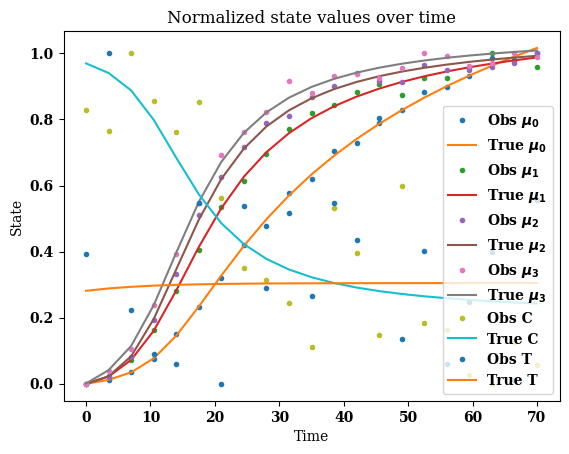

In [18]:
x_true, x_obs, T = create_data(paramzz, T0, TF, steps, step_size, x0)
plot_samples(x_true, x_obs, T)

In [19]:
Qmat = initialise_Qmat(x_obs)
Qmat = Qmat.at[0,0].set(1e-8)
Qmat = Qmat.at[1,1].set(1e-8)
Qmat = Qmat.at[2,2].set(1e-8)
Qmat = Qmat.at[3,3].set(1e-8)
Qmat = Qmat.at[4,4].set(1e-3)
Qmat = Qmat.at[5,5].set(1e-3)

In [20]:
 # Reference loss for the true data generating model

 cost = NLL_true_parameters(paramzz, T0, TF, steps, step_size, x0, x_obs, Qmat)
 print('sum of stage costs', cost)

20
State error at index 0 [ 3.99206543e+00 -1.19208984e+02  3.50612500e+04 -3.18864000e+06
 -2.46065855e-03  2.96795654e+00] 
NLL contribution at index 0 is 101686.5546875
State error at index 1 [-3.3585449e+01  1.6268828e+03 -1.7804150e+05 -5.2600000e+06
 -3.0856878e-03  1.8841003e+01] 
NLL contribution at index 1 is 276993.34375
State error at index 2 [ 4.4711230e+02  2.3939219e+03 -2.4560050e+05 -3.1659648e+07
  1.9636750e-03 -1.8225708e+00] 
NLL contribution at index 2 is 10023936.0
State error at index 3 [-5.5885547e+02  8.2650938e+03 -2.9590500e+05 -2.8053760e+06
  1.0041595e-03 -5.5096130e+00] 
NLL contribution at index 3 is 79577.65625
State error at index 4 [ 1.5301797e+03 -1.3878125e+03 -9.0345400e+05 -1.9518080e+07
  1.3380349e-03 -6.3503723e+00] 
NLL contribution at index 4 is 3817716.75
State error at index 5 [-5.2269531e+02 -2.1215125e+04  9.0662000e+05 -1.5800064e+07
  4.8711151e-03  6.4943848e+00] 
NLL contribution at index 5 is 2504644.0
State error at index 6 [-2.2915

In [21]:
N_TARGETS = 1
N_INPUTS = 1
SIZES = [N_INPUTS, 10, 2, N_TARGETS]
GAMMA = 0.00008
rng = jnr.PRNGKey(10)
NUM_EPOCHS = 100


# Initialize bnn model
bnn_params = init_bnn_params(rng, SIZES)


import numpy as np
from pyswarm import pso  # If not installed, run `pip install pyswarm`
import jax.random as jnr
import jax.numpy as jnp

# Define the wrapper function to initialize the BNN parameters
def init_layer(m, n, rng):
    Wm_rng, bm_rng = jnr.split(rng, 2)
    std = 1.0 / jnp.sqrt(n)
    W_mu = jnr.uniform(Wm_rng, (n, m), minval=-std, maxval=std)
    b_mu = jnr.uniform(bm_rng, (n, 1), minval=-std, maxval=std)

    params = {'W': W_mu, 'b': b_mu}
    return params

def init_bnn_params(init_rng, sizes):
    rngs = jnr.split(init_rng, len(sizes))
    return {i: init_layer(m, n, k) for i, (k, m, n) in enumerate(zip(rngs, sizes[:-1], sizes[1:]))}

# Flatten the bnn_params dictionary for use in PSO
def flatten_bnn_params(bnn_params):
    flat_params = []
    for layer_params in bnn_params.values():
        flat_params.append(layer_params['W'].ravel())
        flat_params.append(layer_params['b'].ravel())
    return np.concatenate(flat_params)

# Reconstruct the bnn_params dictionary from flat_params
def unflatten_bnn_params(flat_params, sizes):
    bnn_params = {}
    index = 0
    for i, (m, n) in enumerate(zip(sizes[:-1], sizes[1:])):
        W_size = n * m
        b_size = n

        W = flat_params[index:index + W_size].reshape((n, m))
        index += W_size
        b = flat_params[index:index + b_size].reshape((n, 1))
        index += b_size

        bnn_params[i] = {'W': W, 'b': b}
    return bnn_params

# Define the target function wrapper for PSO
def NLL_hybrid_flattened_params(flat_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat, sizes):
    bnn_params = unflatten_bnn_params(flat_params, sizes)
    return NLL_hybrid_parameters(bnn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat)

# Define the Particle Swarm Optimization (PSO) function
def particle_swarm_optimize_NLL(rng, t0, tf, steps, step_size, x0, x_obs, Qmat, sizes, num_particles=50, max_iter=100):
    # Flatten initial parameters to determine dimensionality
    example_bnn_params = init_bnn_params(rng, sizes)
    flat_example_params = flatten_bnn_params(example_bnn_params)
    dim = flat_example_params.shape[0]

    # Define the bounds for each parameter; adjust as needed
    lb = -1.0 * np.ones(dim)  # lower bounds for each parameter
    ub = 1.0 * np.ones(dim)   # upper bounds for each parameter

    # Run PSO to minimize the NLL function
    best_params, best_cost = pso(
        NLL_hybrid_flattened_params,
        lb,
        ub,
        args=(rng, t0, tf, steps, step_size, x0, x_obs, Qmat, sizes),
        swarmsize=num_particles,
        maxiter=max_iter
    )

    # Reconstruct the best bnn_params dictionary from the best parameters
    bnn_params_best = unflatten_bnn_params(best_params, sizes)
    return bnn_params_best, best_cost


In [ ]:
bnns_params_best, best_cost = particle_swarm_optimize_NLL(rng, T0, TF, steps, step_size, x0, x_obs, Qmat, SIZES, num_particles=5, max_iter=10)


In [ ]:
lossvals = []
bnn_params = bnns_params_best

# ---- ADAM optimizer (works pretty well here) ---- #

linear_decay_scheduler = optax.linear_schedule(init_value=0.001, end_value=0.0000009,
                                               transition_steps=NUM_EPOCHS,
                                               transition_begin=int(NUM_EPOCHS*0.25))

optimizer = optax.adam(linear_decay_scheduler)
opt_state = optimizer.init(bnn_params)

def train_step(opt_state, bnn_params):
  lossval, grads = grad_f(bnn_params, rng, T0, TF, steps, step_size, x0, x_obs, Qmat)
  updates, opt_state = optimizer.update(grads, opt_state, bnn_params)
  bnn_params = optax.apply_updates(bnn_params, updates)
  return lossval, opt_state, bnn_params

for epoch in range(NUM_EPOCHS):
  print(epoch)
  lossval, opt_state, bnn_params = train_step(opt_state, bnn_params)
  lossvals.append(lossval)
  if (epoch + 1) % 5 == 0:
     print(f"At epoch {epoch+1} loss = {lossval}")

NameError: name 'bnn_params' is not defined

In [ ]:
# Step LR by 0.75 every 100 steps
font = {'family': 'serif', 'weight': 'bold'}
plt.rc('font', **font)
plt.plot(range(NUM_EPOCHS), jnp.array(lossvals), linestyle='--', color='blue', marker='o', markersize=1)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('NLL Loss', fontsize=12)
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(min(lossvals),2.5e9)
plt.xlim(0,200)
plt.savefig('adjoint_trainer.svg')

plt.show()

In [ ]:
rng = jnr.PRNGKey(11)
histories = []
for n in range(1):
  new_rng, rng = jnr.split(rng)
  x_history = NLL_hybrid_integrator(bnn_params, rng, T0, TF, steps, step_size, x0, x_obs, Qmat)
  histories.append(x_history)

histories = jnp.array(histories)
history_mean = jnp.mean(histories, axis=0)
history_std = jnp.std(histories, axis=0)


In [1]:
font = {'family': 'serif', 'weight': 'bold'}
plt.rc('font', **font)
label_tag = ['$\mu_0$', '$\mu_1$', '$\mu_2$', '$\mu_3$', 'C', 'T']
for i in range(x_obs.shape[1]):
  plt.figure(figsize = (10,8))
  plt.plot(T, x_obs.T[i, :], '.', label = label_tag[i])
  plt.plot(T, history_mean.T[i, :], '-', label = 'Hybrid ' + label_tag[i])
  plt.plot(T, x_true.T[i, :], '-', label = 'Mechanistic ' + label_tag[i])
  plt.legend()
  plt.xlabel("Time")
  plt.ylabel(label_tag[i])
  plt.xlim(0,70)
  plt.savefig(label_tag[i] + '.svg')
  plt.show()


NameError: name 'plt' is not defined